In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
img = h5py.File('archive/BraTS2020_training_data/content/data/volume_1_slice_0.h5', 'r')

In [4]:
print(img.keys())

<KeysViewHDF5 ['image', 'mask']>


In [4]:
folder_path = "archive/BraTS2020_training_data/content/data"

In [5]:
df = pd.read_csv(folder_path + "/survival_info.csv", delimiter=";")

In [4]:
print(df.shape)

(236, 4)


In [5]:
print(df.head())

              Brats20ID     Age Survival_days Extent_of_Resection
0  BraTS20_Training_001  60.463           289                 GTR
1  BraTS20_Training_002  52.263           616                 GTR
2  BraTS20_Training_003  54.301           464                 GTR
3  BraTS20_Training_004  39.068           788                 GTR
4  BraTS20_Training_005  68.493           465                 GTR


In [6]:
import re


def extract_days(value):
        match = re.search(r'\((\d+) days later\)', str(value)) #handles the 'ALIVE (xxx days later)' case.
        if match:
            return int(match.group(1))
        else:
            try:
                return int(value) #handles cases that are already integers.
            except (ValueError, TypeError):
                return None  # Or handle other invalid values as needed (e.g., replace with NaN)


In [7]:
df['Survival_days'] = df['Survival_days'].apply(extract_days)

In [8]:
df['Age'] = df['Age'].astype(int)
df['Survival_days'] = df['Survival_days'].astype(int)

In [9]:
print(df.describe())

              Age  Survival_days
count  236.000000     236.000000
mean    60.754237     445.453390
std     11.866948     355.158044
min     18.000000       5.000000
25%     54.000000     190.000000
50%     61.000000     369.000000
75%     69.000000     579.250000
max     86.000000    1767.000000


Survival Days are between 5 and 1767. What is the output of my model? Do i want it to predict exactly the number of days (not feasible).

I have to split the interval in multiple classes. How many?
One approach was to have 3 classes: short-survivors, mid-survivors and long-survivors - is it feasible like this?
But how do I split the intervals? Are they equal to the interval or do they have a clinical semantic significance? Where do I find the answer? Who do I ask?

In [10]:
files = os.listdir(folder_path)
print(len(files))

57198


In [6]:
import h5py
import numpy as np
import os
import re

def load_all_volumes_with_gt(folder_path):
    """
    Loads all MRI volumes and their corresponding ground truth (masks)
    from .h5py slice files in a folder.

    Args:
        folder_path (str): Path to the folder containing the .h5py slice files
                           named like "volume_{volume_index}_slice_{slice_index}.h5".
                           Each file is expected to contain 'image' and 'mask' datasets.

    Returns:
        dict: A dictionary where keys are volume indices (integers) and
              values are dictionaries containing:
                'image': A 4D NumPy array representing the MRI volume
                         (num_slices, height, width, num_channels).
                'mask': A 3D NumPy array representing the ground truth mask
                        (num_slices, height, width).
              Returns an empty dictionary if no volumes are found or if 'image'
              or 'mask' are not present in the files.
    """
    all_volumes_data = {}
    slice_files = [f for f in os.listdir(folder_path) if f.endswith(".h5") and f.startswith("volume_")]

    if not slice_files:
        print(f"No .h5 slice files found in {folder_path}")
        return all_volumes_data

    # Group files by volume index
    volume_files = {}
    for filename in slice_files:
        match = re.match(r"volume_(\d+)_slice_(\d+)\.h5", filename)
        if match:
            volume_index = int(match.group(1))
            if volume_index not in volume_files:
                volume_files[volume_index] = []
            volume_files[volume_index].append(filename)

    # Load slices and stack them for each volume
    for volume_index, files in sorted(volume_files.items()):
        image_slices = []
        mask_slices = []
        sorted_files = sorted(files, key=lambda f: int(re.match(r"volume_\d+_slice_(\d+)\.h5", f).group(1)))
        volume_corrupted = False

        for filename in sorted_files:
            file_path = os.path.join(folder_path, filename)
            try:
                with h5py.File(file_path, 'r') as hf:
                    image_data = hf.get('image')
                    mask_data = hf.get('mask')

                    if image_data is not None and mask_data is not None:
                        image_slices.append(image_data[:])
                        mask_slices.append(mask_data[:])
                    else:
                        print(f"Warning: Missing 'image' or 'mask' key in {filename}. Skipping volume {volume_index}.")
                        volume_corrupted = True
                        break
            except Exception as e:
                print(f"Error reading {filename}: {e}. Skipping volume {volume_index}.")
                volume_corrupted = True
                break

        if not volume_corrupted and image_slices and mask_slices:
            try:
                # Stack slices along the first dimension
                volume_3d = np.stack(image_slices, axis=0)
                mask_3d = np.stack(mask_slices, axis=0)
                all_volumes_data[volume_index] = {'image': volume_3d, 'mask': mask_3d}
            except ValueError as e:
                print(f"Error stacking slices for volume {volume_index}: {e}. Skipping volume.")
        elif volume_corrupted:
            if volume_index in all_volumes_data:
                del all_volumes_data[volume_index]

    return all_volumes_data

In [23]:
def load_specific_volume_with_gt(folder_path, volume_index_to_load):
    """
    Loads a specific MRI volume and its corresponding ground truth (mask)
    from .h5py slice files in a folder.

    Args:
        folder_path (str): Path to the folder containing the .h5py slice files
                           named like "volume_{volume_index}_slice_{slice_index}.h5".
                           Each file is expected to contain 'image' and 'mask' datasets.
        volume_index_to_load (int): The index of the volume to load.

    Returns:
        dict or None: A dictionary containing 'image' and 'mask' for the specified volume,
                     or None if the volume is not found or if 'image' or 'mask' are
                     not present in the files for that volume.
                     The dictionary has the following structure:
                        'image': A 4D NumPy array representing the MRI volume
                                 (num_slices, height, width, num_channels).
                        'mask': A 3D NumPy array representing the ground truth mask
                                (num_slices, height, width).
    """
    slice_files = [f for f in os.listdir(folder_path) if f.endswith(".h5") and f.startswith("volume_")]

    if not slice_files:
        print(f"No .h5 slice files found in {folder_path}")
        return None

    target_volume_files = [f for f in slice_files if re.match(rf"volume_({volume_index_to_load})_slice_\d+\.h5", f)]

    if not target_volume_files:
        print(f"No slice files found for volume {volume_index_to_load} in {folder_path}")
        return None

    image_slices = []
    mask_slices = []
    sorted_files = sorted(target_volume_files, key=lambda f: int(re.match(rf"volume_{volume_index_to_load}_slice_(\d+)\.h5", f).group(1)))
    volume_corrupted = False

    for filename in sorted_files:
        file_path = os.path.join(folder_path, filename)
        try:
            with h5py.File(file_path, 'r') as hf:
                image_data = hf.get('image')
                mask_data = hf.get('mask')

                if image_data is not None and mask_data is not None:
                    image_slices.append(image_data[:])
                    mask_slices.append(mask_data[:])
                else:
                    print(f"Warning: Missing 'image' or 'mask' key in {filename} for volume {volume_index_to_load}.")
                    return None
        except Exception as e:
            print(f"Error reading {filename} for volume {volume_index_to_load}: {e}")
            return None

    if image_slices and mask_slices:
        try:
            volume_3d = np.stack(image_slices, axis=0)
            mask_3d = np.stack(mask_slices, axis=0)
            return {volume_index_to_load: {'image': volume_3d, 'mask': mask_3d}}
        except ValueError as e:
            print(f"Error stacking slices for volume {volume_index_to_load}: {e}")
            return None
    else:
        print(f"No valid image or mask slices found for volume {volume_index_to_load}.")
        return None

In [24]:
folder_path = "archive/BraTS2020_training_data/content/data"  # Replace with the actual path to your folder

first_volume_data = load_specific_volume_with_gt(folder_path, 2)

In [41]:
def plot_random_slices_for_modalities(all_volumes, volume_index=0): # Default volume_index to 0
    """
    Plots a random slice for each of the four modalities (channels) for a given volume.

    Args:
        all_volumes (dict): A dictionary where keys are volume indices and values are
                            dictionaries containing 'image' (NumPy array of shape
                            (num_slices, height, width, num_channels)) and 'mask'.
        volume_index (int): The index of the volume to plot (default is 0).
    """
    if volume_index not in all_volumes:
        print(f"Volume {volume_index} not found in the loaded data.")
        return

    volume_data = all_volumes[volume_index]['image']

    if volume_data.shape != (155, 240, 240, 4):
        print(f"Unexpected shape for volume {volume_index}: {volume_data.shape}.  Expected (155, 240, 240, 4).")
        return

    num_slices = volume_data.shape[0]
    # random_slice_index = np.random.randint(0, num_slices)
    random_slice_index = 65

    modalities = ["T1", "T1 with contrast", "T2", "T2 flair"]
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Create a figure and 4 subplots

    for i in range(4):
        slice_data = volume_data[random_slice_index, :, :, i]
        axes[i].imshow(slice_data, cmap='gray')
        axes[i].set_title(f'{modalities[i]} - Slice {random_slice_index}')
        axes[i].axis('off')  # Hide axis labels and ticks

    plt.suptitle(f'Random Slices for Each Modality - Volume {volume_index}')
    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

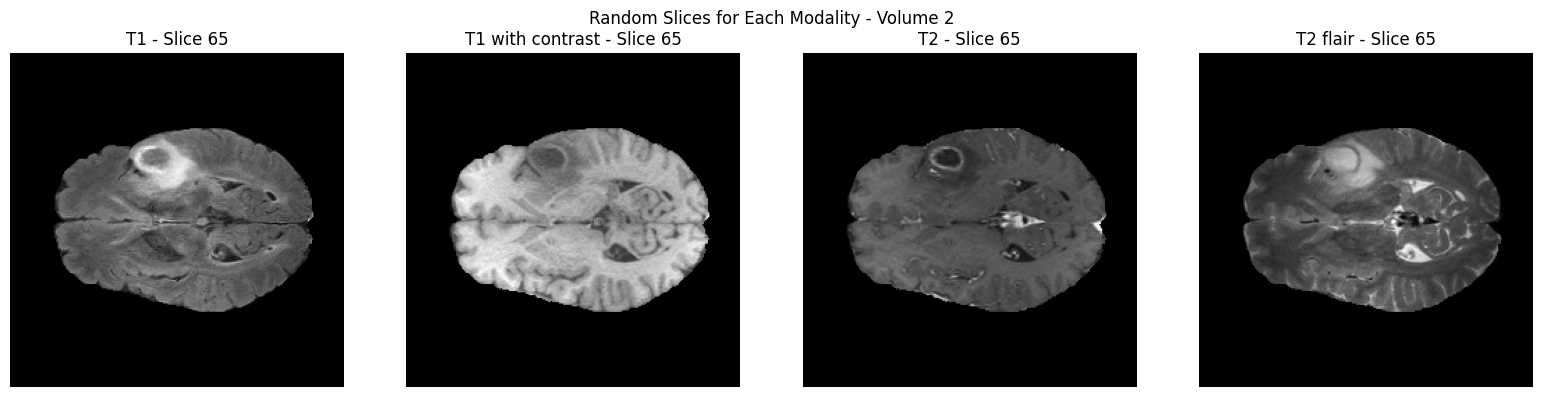

In [42]:
first_volume_index = list(first_volume_data.keys())[0]
plot_random_slices_for_modalities(first_volume_data, volume_index=first_volume_index)

In [43]:
image_data = first_volume_data[first_volume_index]['image']
image_shape = image_data.shape
print("Shape of the first volume's image data:", image_shape)

# You can also get the shape of the mask data similarly
mask_data = first_volume_data[first_volume_index]['mask']
mask_shape = mask_data.shape
print("Shape of the first volume's mask data:", mask_shape)

Shape of the first volume's image data: (155, 240, 240, 4)
Shape of the first volume's mask data: (155, 240, 240, 3)


In [44]:
def plot_mask_pixel_distribution_all_channels(all_volumes, volume_index=0):
    """
    Plots the distribution of pixel values for all channels of the mask data
    of a given volume using histograms in separate subplots.

    Args:
        all_volumes (dict): A dictionary where keys are volume indices and values are
                            dictionaries containing 'image' and 'mask' (NumPy arrays).
        volume_index (int): The index of the volume to analyze (default is 0).
    """
    if volume_index not in all_volumes:
        print(f"Volume {volume_index} not found in the loaded data.")
        return

    mask_data = all_volumes[volume_index]['mask']

    if len(mask_data.shape) != 4:
        print(f"Unexpected shape for mask of volume {volume_index}: {mask_data.shape}. Expected 4 dimensions.")
        return

    num_channels = mask_data.shape[-1]
    fig, axes = plt.subplots(1, num_channels, figsize=(6 * num_channels, 5))  # Adjust figure size as needed

    for i in range(num_channels):
        channel_data = mask_data[:, :, :, i].flatten()
        if num_channels == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.hist(channel_data, bins=50, color='skyblue', edgecolor='black')
        ax.set_title(f'Channel {i}')
        ax.set_xlabel('Pixel Value')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.75)

    plt.suptitle(f'Pixel Value Distribution - Mask (Volume {volume_index}, All Channels)')
    plt.tight_layout()
    plt.show()

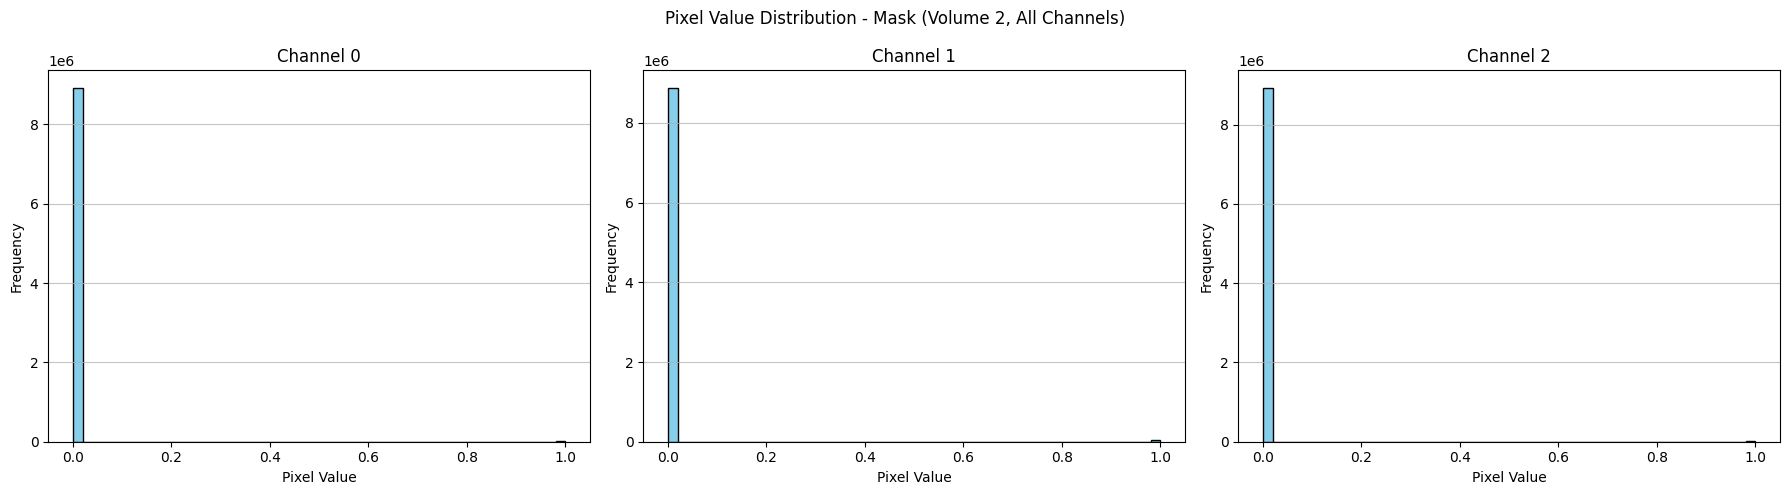

In [45]:
plot_mask_pixel_distribution_all_channels(first_volume_data ,first_volume_index)

In [48]:
def plot_mask_slices_all_channels(all_volumes, volume_index=0):
    """
    Plots a random slice of the mask data for all channels of a given volume.

    Args:
        all_volumes (dict): A dictionary where keys are volume indices and values are
                            dictionaries containing 'image' and 'mask' (NumPy arrays).
        volume_index (int): The index of the volume to plot (default is 0).
    """
    if volume_index not in all_volumes:
        print(f"Volume {volume_index} not found in the loaded data.")
        return

    mask_data = all_volumes[volume_index]['mask']

    if len(mask_data.shape) != 4 or mask_data.shape[:3] != (155, 240, 240):
        print(f"Unexpected shape for mask of volume {volume_index}: {mask_data.shape}. Expected (155, 240, 240, num_channels).")
        return

    num_slices = mask_data.shape[0]
    # random_slice_index = np.random.randint(0, num_slices)
    random_slice_index = 65
    num_channels = mask_data.shape[-1]

    fig, axes = plt.subplots(1, num_channels, figsize=(6 * num_channels, 6))  # Create subplots for all channels

    for i in range(num_channels):
        slice_data = mask_data[random_slice_index, :, :, i]
        if num_channels == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(slice_data, cmap='gray')
        ax.set_title(f'Channel {i}')
        ax.axis('off')

    plt.suptitle(f'Mask - Volume {volume_index}, Slice {random_slice_index}, All Channels')
    plt.tight_layout()
    plt.show()

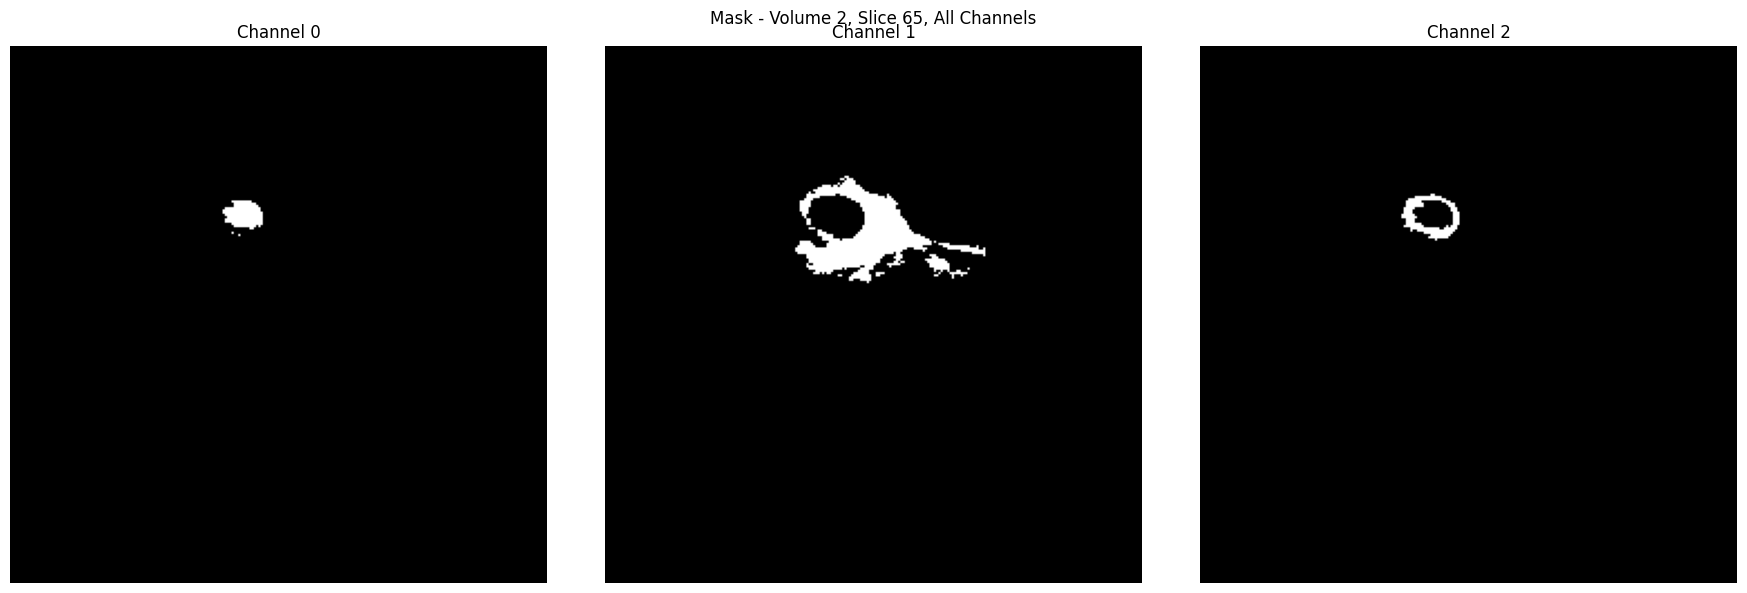

In [49]:
plot_mask_slices_all_channels(first_volume_data, volume_index=first_volume_index)

The output of these masks have 3 channels:
- the GD-enhancing tumor: ET — label 4
- the peritumoral edema: ED — label 2
- the necrotic and non-enhancing tumor core: NCR/NET — label 1